In [2]:
#importing libraries


import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor

import os


# Step 1 - Load Dataset

In [5]:
data = pd.read_csv('kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
#copying data to another dataframe so our OG dataframe remains intact

data_train = data.copy()
data_train.rename(columns={'price': 'SalePrice'}, inplace=True)

In [7]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Only date is categorical and we will not use it so no need to update. ALso there are no missing values

### Finding correlations

In [8]:
#id and date are not important so we are removing them

#all rows and columns 4 to end
features = data.iloc[:,3:].columns.tolist()

#all rows and column 3
target = data.iloc[:, 2].name

In [13]:
#finding correlations of target with other features

correlations = {}

for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [14]:
#pritning all correlations with respect to target

data_correl = pd.DataFrame(correlations, index=['Value']).T
data_correl.loc[data_correl['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


### Visualising the data

<Figure size 432x288 with 0 Axes>

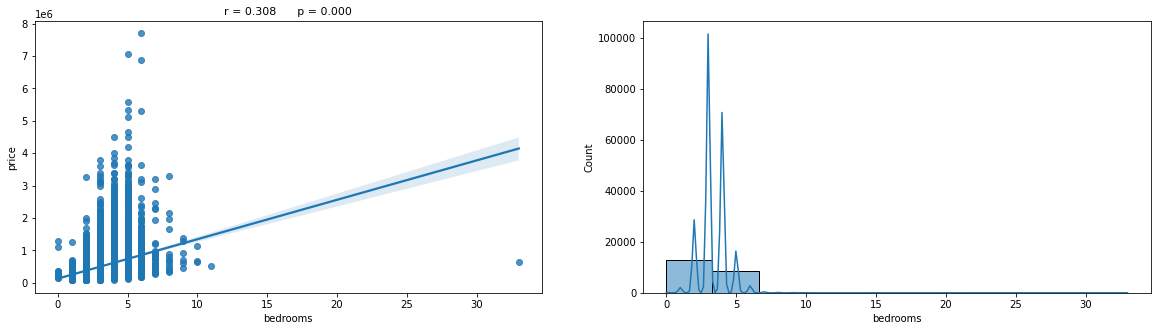

<Figure size 432x288 with 0 Axes>

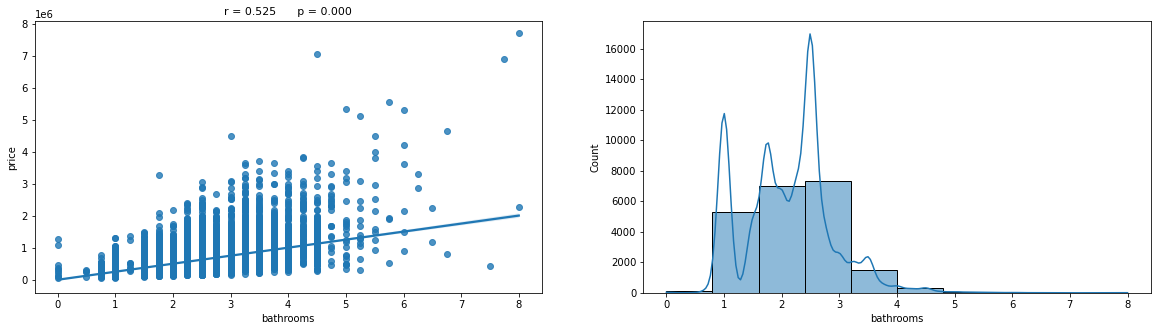

<Figure size 432x288 with 0 Axes>

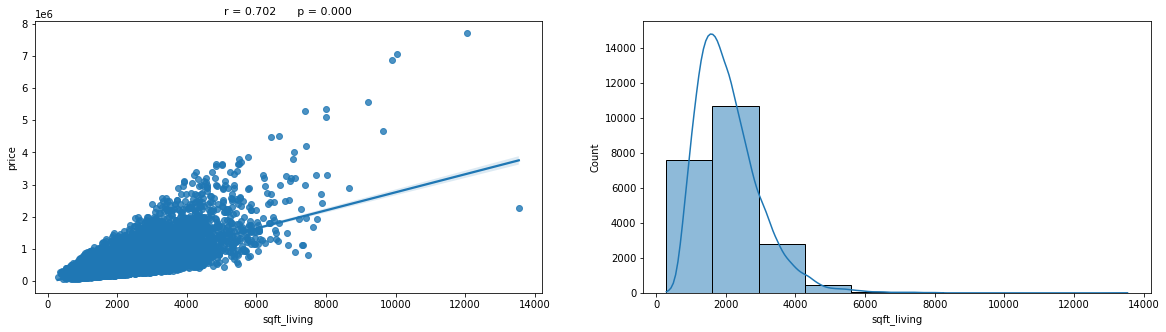

<Figure size 432x288 with 0 Axes>

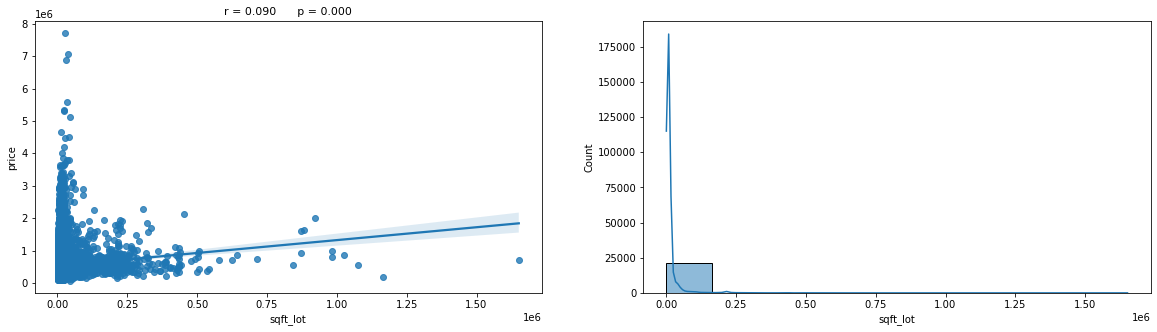

<Figure size 432x288 with 0 Axes>

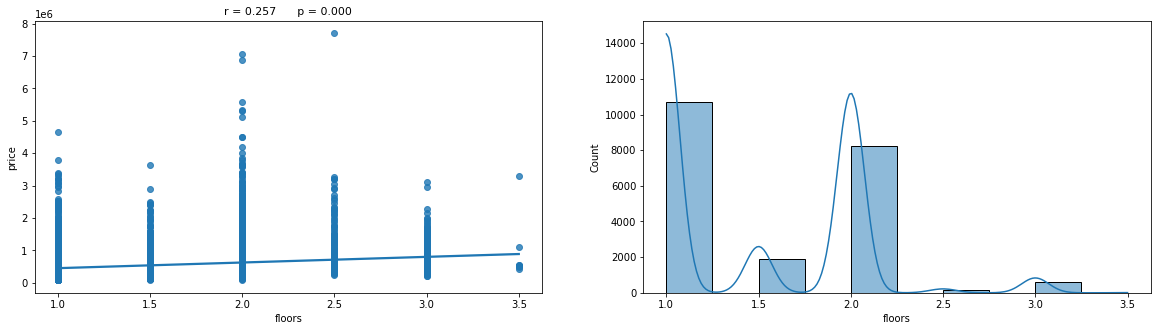

<Figure size 432x288 with 0 Axes>

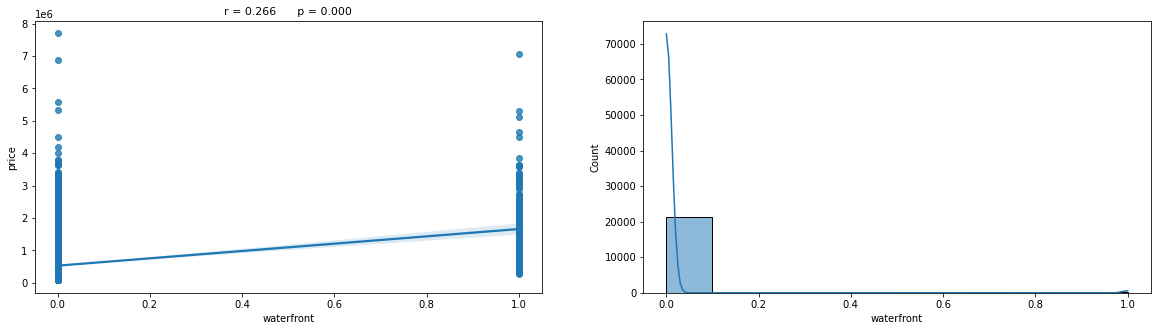

<Figure size 432x288 with 0 Axes>

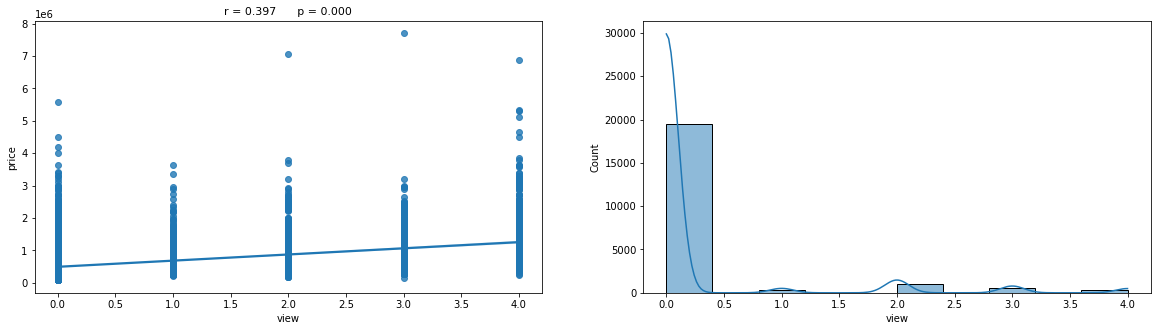

<Figure size 432x288 with 0 Axes>

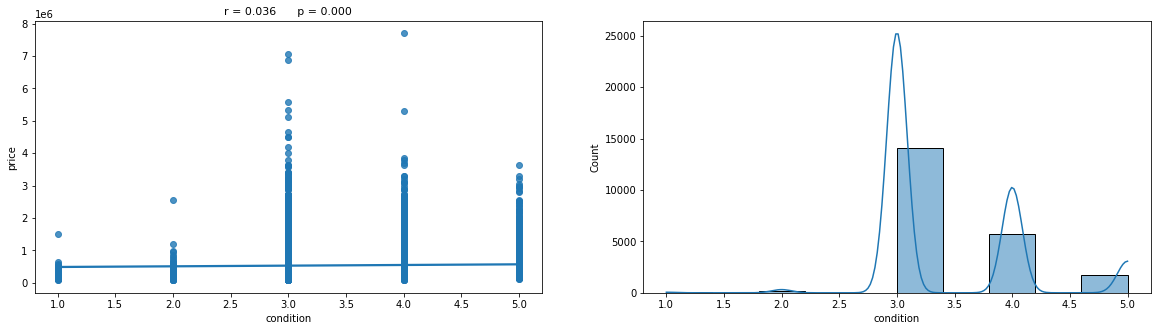

<Figure size 432x288 with 0 Axes>

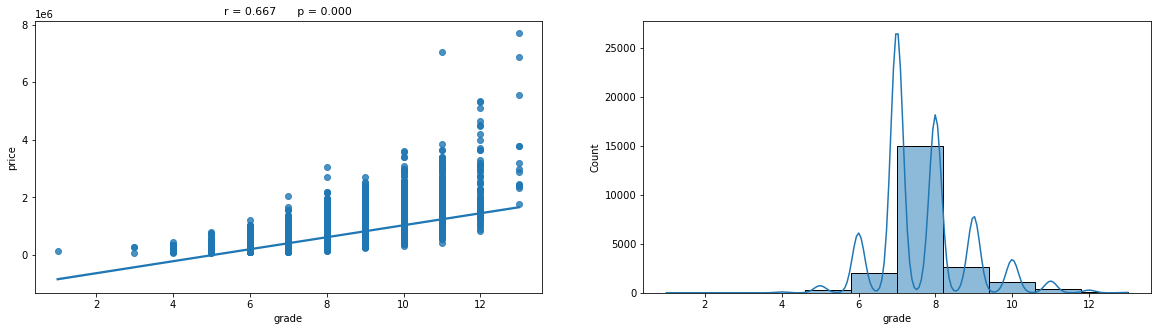

<Figure size 432x288 with 0 Axes>

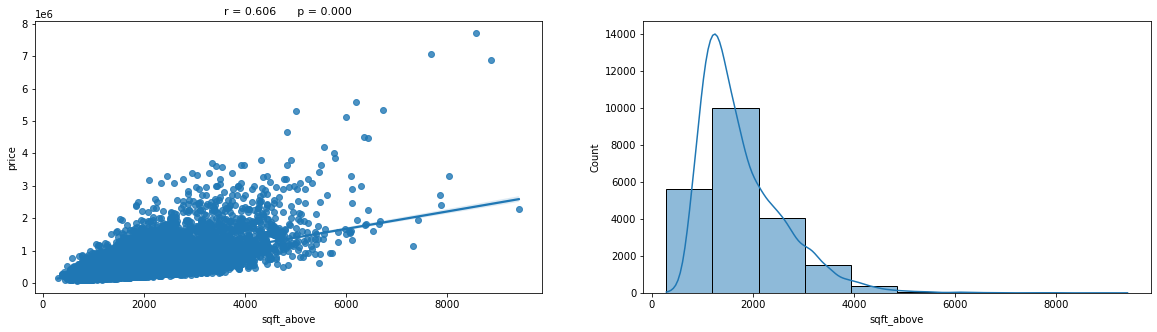

<Figure size 432x288 with 0 Axes>

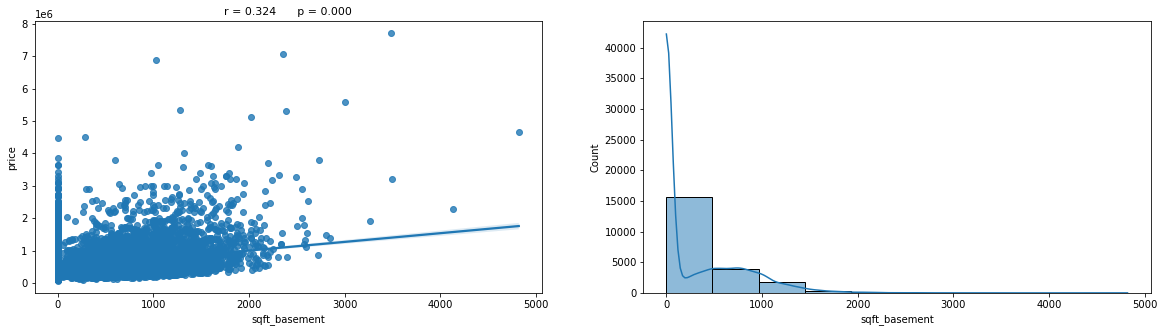

<Figure size 432x288 with 0 Axes>

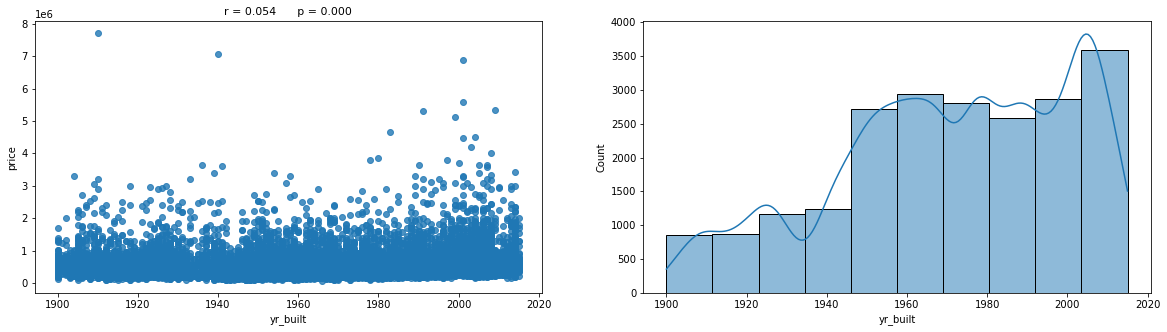

<Figure size 432x288 with 0 Axes>

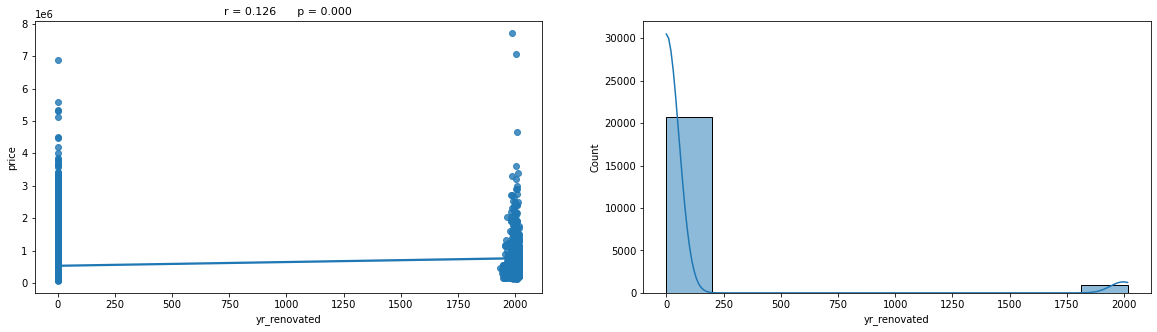

<Figure size 432x288 with 0 Axes>

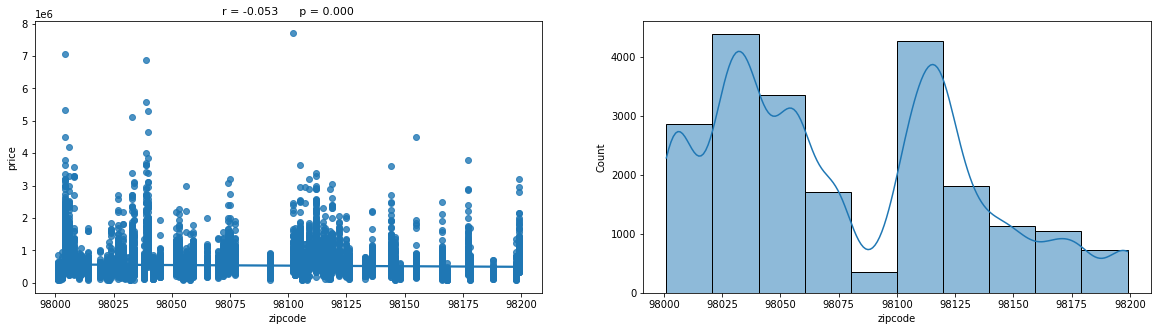

<Figure size 432x288 with 0 Axes>

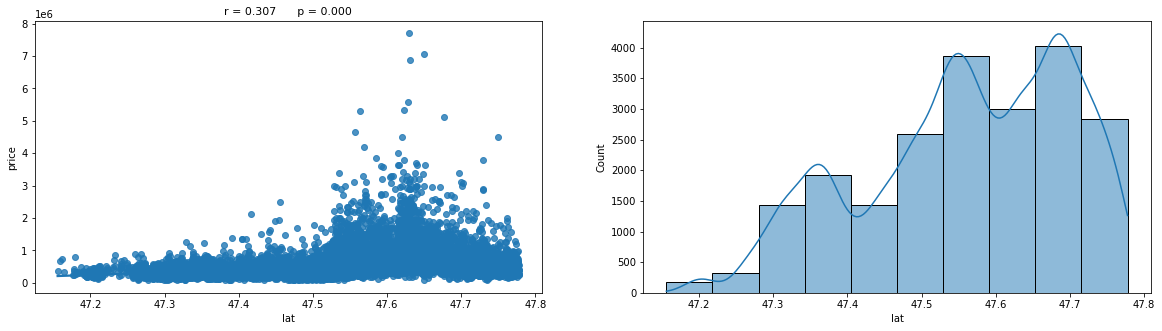

<Figure size 432x288 with 0 Axes>

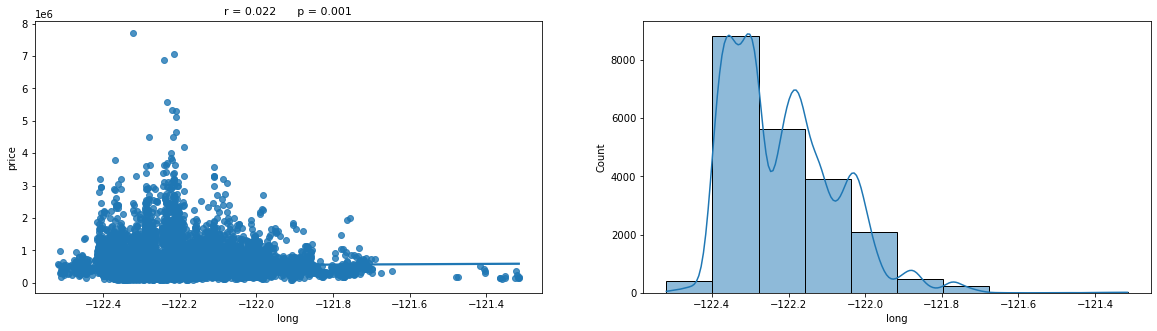

<Figure size 432x288 with 0 Axes>

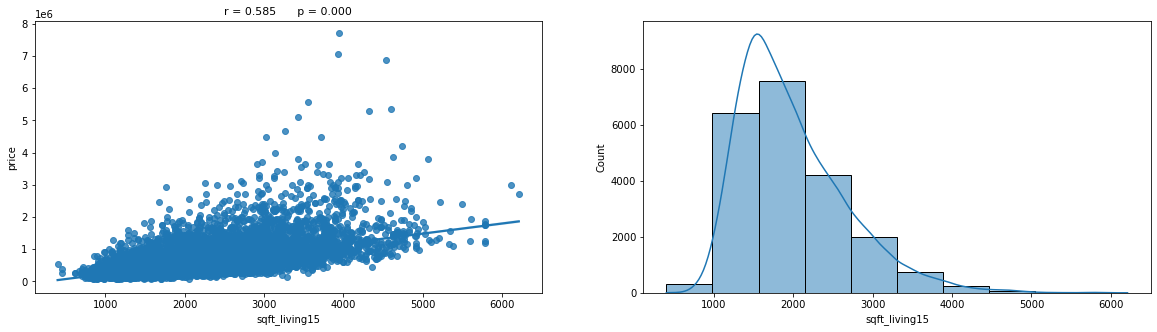

<Figure size 432x288 with 0 Axes>

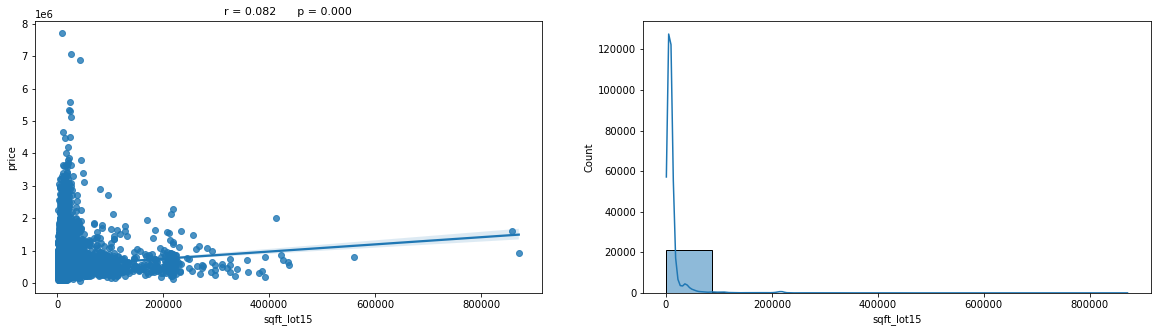

In [19]:
#function for numeric data visualising

def numeric_graphs(df, num_vars, y_value):
    for col in num_vars:
        plt.figure()
        plt.tight_layout()
        plt.figure(figsize=(20,5))

        plt.subplot(1,2,1)
        sns.regplot(x = df[col], y=df[y_value])
        stp = pearsonr(df[col], df[y_value])
        str_title = "r = " + "{0:.3f}".format(stp[0]) + "      " "p = " + "{0:.3f}".format(stp[1])
        plt.gca().set_title(str_title, fontsize=11)
        plt.subplot(1,2,2)
        sns.histplot(df[col], bins=10, kde=True)
        plt.show()
        

numeric_graphs(data, features, 'price')

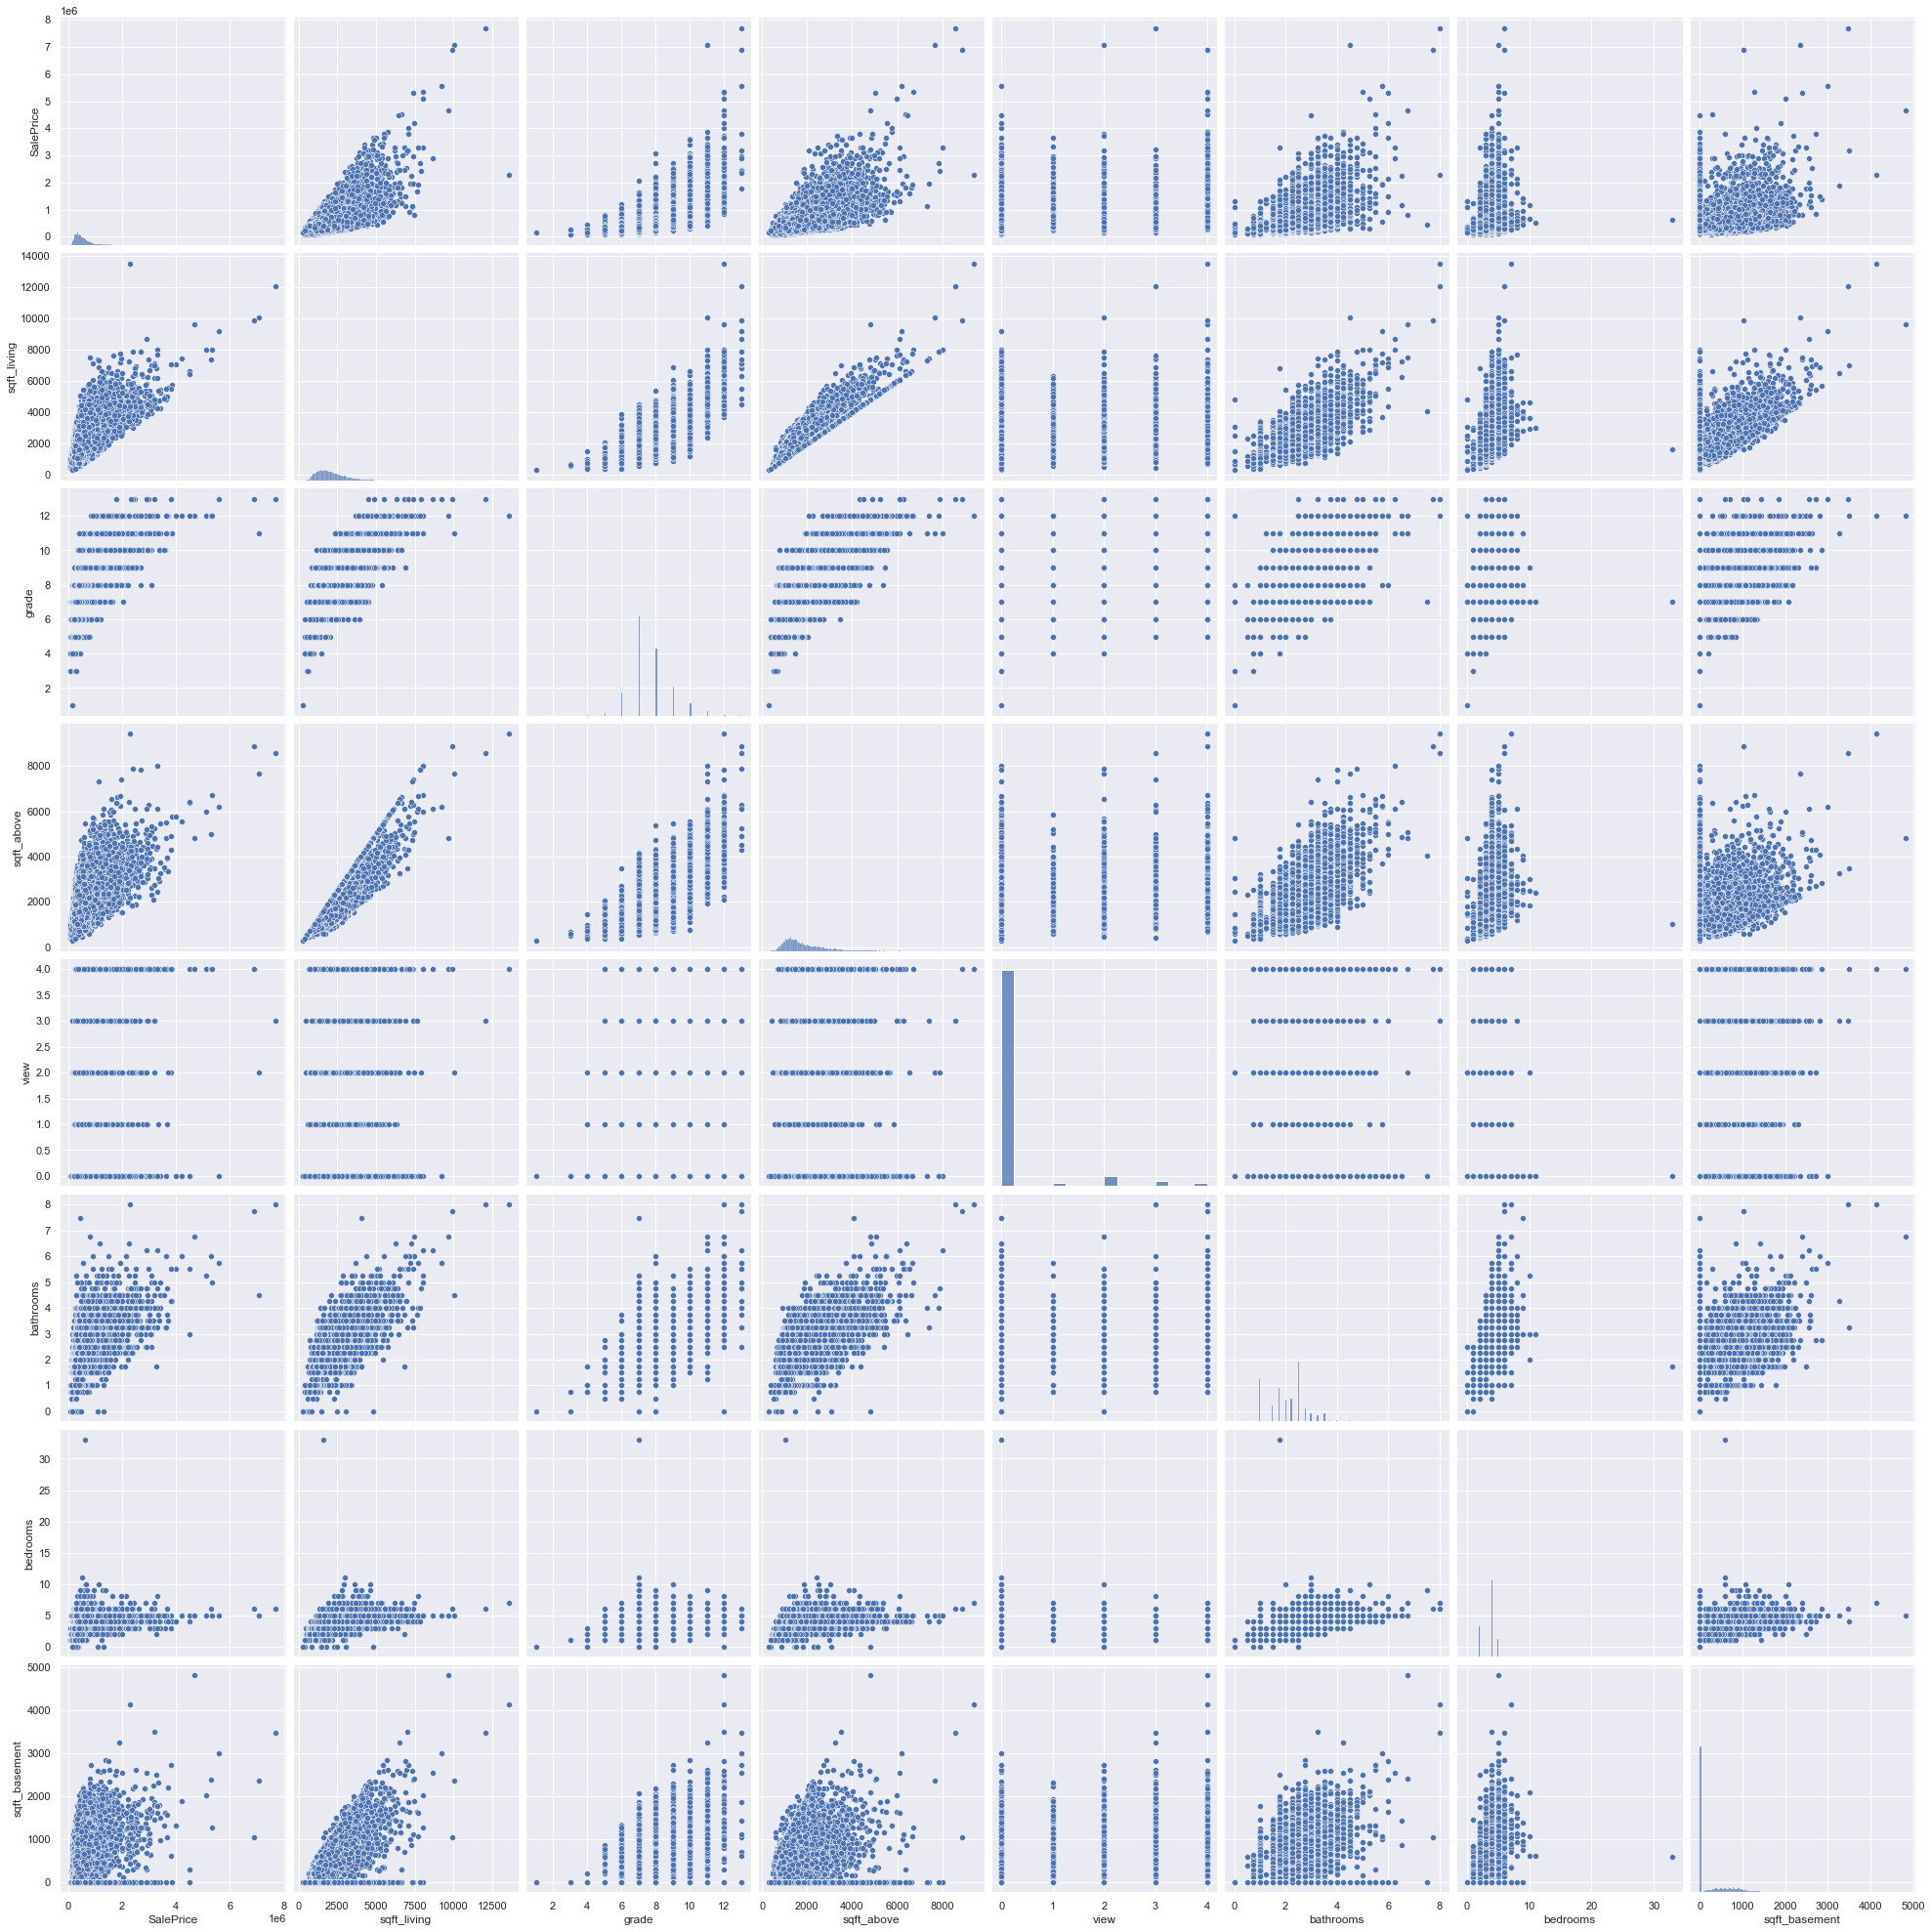

In [20]:
#pairplots another method to visualise

sns.set()
cols = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms', 'bedrooms', 'sqft_basement']
sns.pairplot(data_train[cols], height = 3.5)
plt.show()